## Install Required Libraries

In [1]:
!pip install transformers
!pip install shap
!pip install torchmetrics
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install numpy 
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 KB 40.5 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.6/529.6 KB 6.8 MB/s eta 0:00:0000:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Looking in in

## Import libraries

In [2]:
import pandas as pd 
import scipy as sp
from torch import nn
from transformers import BertModel
import torch
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm
from torchmetrics import AUROC
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from bert_single_utlis import * 
from shap_utlis import *

In [4]:
# add font family into matplotlib and seaborn for showing Chinese Text
font_dirs = ['../fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'SimHei'

sns.set(font_scale=2)
sns.set(font="SimHei")

## Load Dataset

In [5]:
input_path = '../data/'
df = pd.read_csv(input_path+'clean_df.csv')
df.fillna(' ', inplace=True)
df.shape

(20180, 17)

In [6]:
# for each user, keep the most recent 50 records. most users have < 5 records
sort_df = df.sort_values(['event_time'], ascending=True).groupby('user_no')
df = sort_df.head(50).reset_index()
df.shape

(16181, 18)

## Define the input for text-classifier

In [7]:
df['input_info'] = df['clean_title']+ ' ' +df['clean_abstract'] + ' ' + df['tags']
df['input_info'].head(2)

0    U S  stocks declined and oil fell as President...
1    OPEC and its allies including Russia agreed to...
Name: input_info, dtype: object

In [8]:
# split dataset into training, validation and testing dataset
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),[int(.8*len(df)), int(.9*len(df))])
print(len(df_train),len(df_val), len(df_test))

12944 1618 1619


In [9]:
# find the average text length which used as max-length in Tokenizer
length = int(df['input_info'].apply(len).mean())
length = np.min([512, length])
print('length', length)

length 277


## Import tokenizer and BERT 

In [10]:
# initialize tokenizer and bert model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case = True)
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# build text-classifier model
model = BertClassifier(bert_model, bert_freeze=False)

In [17]:
# classification metric: ROC-AUC
auroc = AUROC(num_classes=2)

In [18]:
# construct pytorch Dataset 
train_dataset, val_dataset, test_dataset = Dataset(df_train, length, tokenizer), Dataset(df_val, length, tokenizer), Dataset(df_test, length, tokenizer)

In [19]:
# hyperparameters for training 
EPOCHS = 10
LR = 1e-5
BATCH_SIZE = 16

## Train model

In [20]:
# train the text-classifier model
train_acc_list, train_auc_list, val_acc_list, val_auc_list = train_model(model, train_dataset, val_dataset, auroc, LR, EPOCHS, BATCH_SIZE)

len(train_data_loader) 809
device ~~~~~~~  cuda


100%|██████████| 809/809 [01:24<00:00,  9.59it/s]


Epochs: 1 | Train Loss:  0.044                 | Train Accuracy:  0.591                 | Train AUC:  0.521                | Val Loss:  0.044                 | Val Accuracy:  0.690                | Val AUC:  0.502


## Eval Model

In [21]:
# evaluate the text-classifier model
auroc = AUROC(num_classes=2)

evaluate_model(model, test_dataset, auroc, BATCH_SIZE)

device ~~~~~~~  cuda
Test Accuracy:  0.711             | Test AUC:  0.497


In [ ]:
# # torch.save(model, '../saved_models/bert_model.pt')
# # model = torch.load('../saved_models/bert_model.pt')
# # device = torch.device('cuda')
# # model.to(device)

## Build SHAP explainer

In [22]:
import shap

In [23]:
# define the classifier model which will be used in SHAP
def classifier_model(x):
    tv = [tokenizer(v, padding='max_length', max_length=200, truncation=True) for v in x]
    mask = torch.tensor([tv[i]['attention_mask'] for i in range(x.shape[0])]).unsqueeze(1).cuda()
    input_id = torch.tensor([tv[i]['input_ids'] for i in range(x.shape[0])]).cuda()
    logits = model(input_id, mask).detach().cpu().numpy()
    scores = (np.exp(logits).T / np.exp(logits).sum(-1)).T
    outputs = scores[:,1]
    return outputs

In [24]:
# # test classifier_model to make sure it works as expected
# df_try = df[['input_info']][:10]
# classifier_model(df_try['input_info'])

In [25]:
# construct SHAP explainer: combine SHAP and classificer model
explainer = shap.Explainer(classifier_model, tokenizer)

## Run SHAP explainer 

In [26]:
# select test input for SHAP explainer: only select data rows with label==1 (positive data rows)
shap_input = df[df.key_label == 1]['input_info'][:10].values

In [27]:
# calculate the shaply value of input
shap_values = explainer(shap_input)

Partition explainer: 11it [00:17,  3.48s/it]                        


## Show shaply value of tokens in single input text

In [28]:
shap.plots.text(shap_values[3])

In [29]:
# shap.plots.text(shap_values[3], grouping_threshold=5)

In [30]:
# shap.plots.text(shap_values[3], grouping_threshold=10)

## Show Bar Plots

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


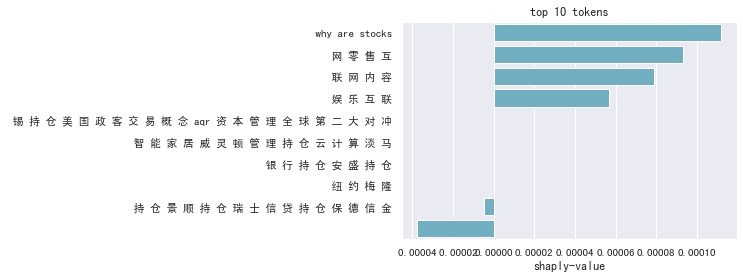

In [31]:
show_top_n_tokens(shap_values, top_n=10, grouping_threshold=0.01)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


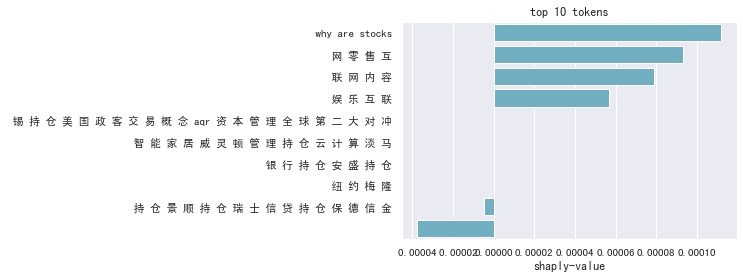

In [32]:
show_top_n_tokens(shap_values, top_n=10, grouping_threshold=1)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


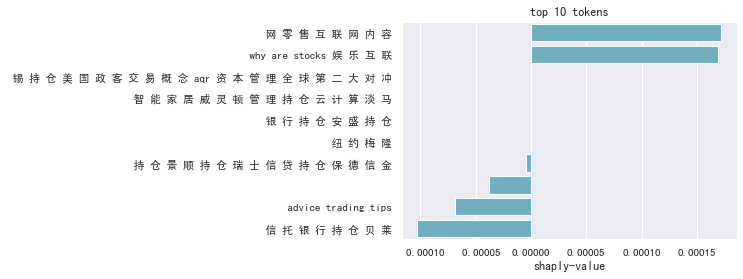

In [33]:
show_top_n_tokens(shap_values, top_n=10, grouping_threshold=5)

In [34]:
# from scipy.cluster.hierarchy import dendrogram
# values, clustering = unpack_shap_explanation_contents(shap_values[0])
# fig = plt.figure(figsize=(12, 6))
# dn = dendrogram(clustering)
# plt.show()

## Find shaply value of Tags (industry and concept)

In [35]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [36]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


In [37]:
tags = df['tags'].apply(lambda x: [i for i in x.split(' ')])

In [38]:
# collect all tags
all_tags = []
for tag in tags:
    all_tags.extend(tag)

unique_tags = np.unique(all_tags)

In [39]:
# collect all tokens and shaply values
all_tokens = []
all_values = []
for i, v in enumerate(shap_values):
    values, clustering = unpack_shap_explanation_contents(v)
    tokens, values, group_sizes = process_shap_values(v.data, values, 0.1, '', clustering)
    all_tokens += list(tokens)
    all_values += list(values)

In [40]:
# find the most similar token for each tag 
tag_values = []
for tag in unique_tags:
    matched_token = process.extract(tag, all_tokens, limit=10)[0][0]
    index = np.where(np.array(all_tokens)==matched_token)[0][0]    
    value = all_values[index]
    tag_values.extend([value])

In [41]:
value_index = np.argsort(tag_values)
sorted_values = np.array(tag_values)[value_index]
sorted_tags = list(np.array(unique_tags)[value_index])
data_dict = {'tags': sorted_tags[::-1], 'shaply-value': sorted_values[::-1]}
score_df = pd.DataFrame(data_dict)

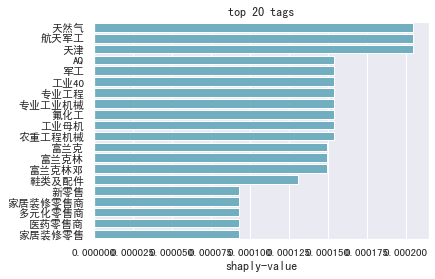

In [42]:
sns.barplot(data=score_df[:20], x="shaply-value", y="tags", color='c')
plt.ylabel('') 
plt.title('top %s tags'%(20), fontsize=12)
plt.show()